In [1]:
import pandas as pd
import numpy as np

In [17]:
from utils import *

In [62]:
import matplotlib.pyplot as plt

In [2]:
df_kb = pd.read_csv('data/massIVE-KB/df_kb_filter.csv')
df_uni = pd.read_csv('data/uniprot/df_uni.csv')

In [3]:
print(df_kb.shape)
df_kb.head(1)

(1991465, 10)


,PEPMASS,CHARGE,FILENAME,SEQ,STRIP_PEPTIDE,SCORE,MZ,INTENSITY,SPECTRAL_CNT,PROTEIN
0,623.327626,3,filtered_library_mgf_files/9187af535f6e41ce958...,+42.011AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,4.605175,129.10317993164062;130.08726501464844;136.0766...,63295.375;7010.876953125;14278.6826171875;5026...,1,sp|Q96A65|EXOC4_HUMAN


In [4]:
print(df_uni.shape)
df_uni.head(1)

(75074, 3)


,PROTEIN,SEQUENCE,PROTEIN_FULL
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,">sp|Q9H553|ALG2_HUMAN Alpha-1,3/1,6-mannosyltr..."


In [5]:
print('uniq STRIP_PEPTIDE cnt : {:,}'.format(len(df_kb.STRIP_PEPTIDE.unique())),
     '\nuniq (CHARGE, STRIP_PEPTIDE) cnt : {:,}'.format(len({(c, s) for c, s in df_kb[['CHARGE', 'STRIP_PEPTIDE']].values})),
     '\nuniq (CHARGE, PEPTIDE) = precursor = pk cnt : {:,}'.format(len(df_kb)),
     '\nuniq PEPTIDE cnt : {:,}'.format(len(df_kb.SEQ.unique())))

uniq STRIP_PEPTIDE cnt : 1,025,874 
uniq (CHARGE, STRIP_PEPTIDE) cnt : 1,457,872 
uniq (CHARGE, PEPTIDE) = precursor = pk cnt : 1,991,465 
uniq PEPTIDE cnt : 1,463,793


In [6]:
print('uniq PEPTIDE with no modi cnt : {:,}'.format(
            len({_ for _ in df_kb.SEQ.unique() if '+' not in _})),
     '\nuniq (CHARGE, PEPTIDE with no modi) cnt : {:,}'.format(
            len({(c, _) for c, _ in df_kb[['CHARGE', 'SEQ']].values if '+' not in _})))

uniq PEPTIDE with no modi cnt : 847,085 
uniq (CHARGE, PEPTIDE with no modi) cnt : 1,192,255


# 생각정리
  - PTM_PEPTIDE(SEQ)도 protein에서 ID된것이긴 하니까 STRIP_PEPTIDE 기준으로 detect 된 것으로 판단해야 한다.
  - point 1
      - PTM_PEPTIDE와 noPTM_PEPTIDE를 STRIP_PEPTIDE로 만들 때, spectral count 합쳐야 할까?  
      - protien 기준에서 id peptide를 판단할 때, PTM없이 판단하므로 합치는게 맞다.
  - point 2
      - PTM_PEPTIDE 의 m/z, intensity 와 noPTM_PEPTIDE 의 m/z, intensity가 다를텐데 prosit 기준값은?
      - spectral count는 합치되 m/z, intensity 는 noPTM_PEPTIDE로 병합하자.
  - point 3
      - CHARGE 마다 spectral count 다른데, 합쳐야할까?
      - 1과 같은 의미로 합치는게 맞다.
      - 다만, m/z, intensity 비교를 위해 charge별 하나를 정해야하므로 별도로 유지한다.

In [7]:
# protein check
p2prot = dict()
for p, prot in df_kb[['STRIP_PEPTIDE', 'PROTEIN']].values:
    if p not in p2prot:
        p2prot[p]=set()
    p2prot[p].add(prot)
    
print('STRIP_PEPTIDE which has protein >2 cnt : ', 
      len([_ for _ in p2prot.values() if len(_) >=2]))

for k, v in p2prot.items():
    k, v = k, *v  # unzip set
    p2prot[k] = v

STRIP_PEPTIDE which has protein >2 cnt :  0


In [8]:
# ptm spectral count merge (plus)
pc2cnt = dict()
for c, p, cnt in df_kb[['CHARGE', 'STRIP_PEPTIDE', 'SPECTRAL_CNT']].values:
    if (p, c) not in pc2cnt:
        pc2cnt[(p, c)] = 0
    pc2cnt[(p, c)] += cnt

In [10]:
# spectrum check
# 84만개의 no PTM PEPTIDE
pc2mz = dict()
pc2int = dict()
for p, c, m, i in df_kb[['SEQ', 'CHARGE', 'MZ', 'INTENSITY']].values:  
    if '+' not in p:
        pc2mz[(p, c)] = m
        pc2int[(p, c)] = i

# spectrum check
# 20만개의 PTM PEPTIDE
noptm_pc = {(_, c) for c, _ in df_kb[['CHARGE', 'SEQ']].values if '+' not in _}
whole_pc = {(_, c) for c, _ in df_kb[['CHARGE', 'STRIP_PEPTIDE']].values}
ptm_pc_candi = {k:set() for k in list(whole_pc.difference(noptm_pc))}

# PTM_PEPTIDE candidate
# ptm_pc_candi = (STRIP_PEPTIDE, CHARGE):(PTM_PEPTIDE, CHARGE)
for c, p, seq in df_kb[['CHARGE', 'STRIP_PEPTIDE', 'SEQ']].values:
    if (p, c) in ptm_pc_candi:
        ptm_pc_candi[(p, c)].add((seq, c))

pc2score_look = {(p, c):score for p, c, score in df_kb[['SEQ', 'CHARGE', 'SCORE']].values}
pc2mz_look = {(p, c):mz for p, c, mz in df_kb[['SEQ' ,'CHARGE', 'MZ']].values}
pc2int_look = {(p, c):i for p, c, i in df_kb[['SEQ' ,'CHARGE', 'INTENSITY']].values}

for k, v in ptm_pc_candi.items():
    if len(v)==1:
        v = list(v)[0]
        pc2mz[k] = pc2mz_look[v]
        pc2int[k] = pc2int_look[v]
    else:  # choose high SCORE's SEQ
        ptm_seqs = {ptm_seq:pc2score_look[ptm_seq] for ptm_seq in v}
        best_v = sorted(ptm_seqs.items(), key=lambda x: x[1], reverse=True)[0][0]  # 내림차순
        pc2mz[k] = pc2mz_look[best_v]
        pc2int[k] = pc2int_look[best_v]

In [11]:
pc = {(p,c) for p, c in df_kb[['STRIP_PEPTIDE', 'CHARGE']].values}
df_ided_peptide = pd.DataFrame([[c, p, p2prot[p], pc2cnt[(p,c)], pc2mz[(p,c)], pc2int[(p,c)]]
                                for p, c in pc],
                              columns=['CHARGE', 'PEPTIDE', 'PROTEINS', 
                                       'SPECTRAL_CNT', 'MZ', 'INTENSITY'])

In [12]:
print(df_ided_peptide.shape)
df_ided_peptide.head(2)

(1457872, 6)


,CHARGE,PEPTIDE,PROTEINS,SPECTRAL_CNT,MZ,INTENSITY
0,2,HLQQYFNLFVMYANLGVAEK,sp|Q93008|USP9X_HUMAN;sp|O00507|USP9Y_HUMAN,2,110.07078552246094;111.0742416381836;119.04860...,458902.59375;19087.873046875;19798.142578125;2...
1,4,SSKLTKDFSALESQLQDTQELLQEENRQK,sp|P35579|MYH9_HUMAN,12,101.0715103149414;102.05558013916016;105.06656...,18141.611328125;10279.7373046875;6992.65087890...


In [ ]:
df_ided_peptide.to_csv('data/massIVE-KB/df_kb_strip.csv', index=False)

# protein filtration
  - only use ided protein (based on massIVE-KB)

In [13]:
ided_protein = list({__ for _ in df_ided_peptide.PROTEINS.values for __ in _.split(';')})
print(len(ided_protein))

19291


In [14]:
df_ided_protein_idx = [idx for idx, p in zip(df_uni.index, df_uni.PROTEIN.values) if p in ided_protein]
df_ided_protein = df_uni.loc[df_ided_protein_idx].reset_index(drop=True)
print(df_ided_protein.shape)
df_ided_protein.head(1)
# pk = PROTEIN

(19291, 3)


,PROTEIN,SEQUENCE,PROTEIN_FULL
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,">sp|Q9H553|ALG2_HUMAN Alpha-1,3/1,6-mannosyltr..."


# Spectral Count
  - on uniprot protiens
  - with massIVE-KB peptides,
  - about spectral_count, spectral_count_miss

In [23]:
def prot2counting(pep_tree, df_prot, df_pep):
    # STRIP_PEPTIDE SPECTRAL_CNT
    pep2cnt = dict()
    for p, cnt in df_pep[['PEPTIDE', 'SPECTRAL_CNT']].values:
        if p not in pep2cnt:
            pep2cnt[p] = 0
        pep2cnt[p] += cnt

    # counting array init
    pep_cnt = [[0 for __ in range(len(_))] for _ in df_prot.SEQUENCE.values]
    miss_cnt = [[0 for __ in range(len(_))] for _ in df_prot.SEQUENCE.values]
    
    # counting start! (protein roop)
    for prot_idx, prot_seq in enumerate(df_prot.SEQUENCE.values):
        if prot_idx % 1000 == 0:
            print('peptide(spectral) counting...', prot_idx, '/', len(df_prot), end='\r')

        # matched peptide in protein
        results = pep_tree.search_all(prot_seq)
        # ex) result = ('ACAC', 5) = (peptide, location)
        for result in results: 
            pep = result[0]
            pep_len = len(result[0])
            start_idx = result[1]
            cnt = pep2cnt[pep]
            
            # miss cleavage case
            if sum([1 for p in pep[:-1] if p in 'KR']) >= 1:
                if pep[-1] in 'KR':  # __KR__KR case
                    miss_change_range = range(start_idx, start_idx + pep_len -1)
                    # miss cleavage count
                    for idx, value in enumerate(miss_cnt[prot_idx]):
                        if idx in miss_change_range:
                            value += cnt
                            miss_cnt[prot_idx][idx] = value
                    # peptide(spectral) count 
                    # only count first, and last amino acid of peptide which include miss cleavage
                    # last : For counting N term of tryptic site
                    # first : Foir counting C term of tryptic site
                    pep_cnt[prot_idx][start_idx + pep_len -1] += cnt
                    pep_cnt[prot_idx][start_idx] += cnt
                else:  # _KR__ case
                    miss_change_range = range(start_idx, start_idx + pep_len)
                    # miss cleavage count
                    for idx, value in enumerate(miss_cnt[prot_idx]):
                        if idx in miss_change_range:
                            value += cnt
                            miss_cnt[prot_idx][idx] = value
            # not miss cleavage case
            else:
                change_range = range(start_idx, start_idx + pep_len)
                # peptide(spectral) count
                for idx, value in enumerate(pep_cnt[prot_idx]):
                    if idx in change_range:
                        value += cnt
                        pep_cnt[prot_idx][idx] = value
    print('peptide(spectral) counting done!                              n')
    
    # peptide(spectral) count with protein
    prot2cnt = dict()
    for idx, ((pname, seqs), cnts) in enumerate(zip(df_prot[['PROTEIN', 'SEQUENCE']].values, pep_cnt)):
        prot2cnt[pname]=';'.join([str(seq) + '_' + str(cnt) for seq, cnt in zip(seqs, cnts)])

    prot2cnt_miss = dict()
    for idx, ((pname, seqs), cnts) in enumerate(zip(df_prot[['PROTEIN', 'SEQUENCE']].values, miss_cnt)):
        prot2cnt_miss[pname] = ';'.join([str(seq) + '_' + str(cnt) for seq, cnt in zip(seqs, cnts)])
    return prot2cnt, prot2cnt_miss

In [18]:
pep_tree = tree_from_pep(df_ided_peptide.PEPTIDE.unique())  # from utils

In [24]:
prot2cnt, prot2cnt_miss = prot2counting(pep_tree, df_ided_protein, df_ided_peptide)

peptide(spectral) counting done!				/ 19291



In [26]:
df_ided_protein['SPECTRAL_CNT'] = [prot2cnt[pname] for pname in df_ided_protein.PROTEIN.values]
df_ided_protein['SPECTRAL_CNT_MISS'] = [prot2cnt_miss[pname] for pname in df_ided_protein.PROTEIN.values]

In [28]:
df_ided_protein.head(1)

,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,">sp|Q9H553|ALG2_HUMAN Alpha-1,3/1,6-mannosyltr...",M_0;A_0;E_0;E_0;Q_0;G_0;R_0;E_3;R_0;D_152;S_2;...,M_0;A_0;E_0;E_0;Q_0;G_0;R_0;E_3;R_3;D_155;S_15...


In [27]:
df_ided_protein.to_csv('data/uniprot/df_uni_ided.csv', index=False)

# Make Detect_pep, unDetect_pep version==whole
  - spectral cnt >= 2 : detect
  - spectral cnt == 0 : undetect

In [31]:
def pep_from_prot(df_uni, MISS_CLEAVAGE, thres=4):
    peptide = []
    TS_AA = 'KR'

    for protein, pname, cnt, cnt_miss in df_uni[['SEQUENCE', 'PROTEIN', 'SPECTRAL_CNT', 'SPECTRAL_CNT_MISS']].values:
        cnt = list(map(lambda x: int(x[2:]), cnt.split(';')))
        cnt_miss = list(map(lambda x: int(x[2:]), cnt_miss.split(';')))
        
        ts_idx = []  # tryptic site index
        for prot_idx, aa in enumerate(protein):
            if aa in TS_AA:
                ts_idx.append(prot_idx)
        for idx in range(len(ts_idx)):
            n = MISS_CLEAVAGE
            if idx+(n+1) > len(ts_idx)-1:  # peptide making range
                break

            # protein N term
            if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            elif ts_idx[idx]<=(thres - 1):
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)]
            elif ts_idx[idx] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
                en = protein[ts_idx[idx]-thres:] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            else:
                en = protein[ts_idx[idx]-thres: ts_idx[idx]+(thres + 1)]

            # protein C term
            if (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)) and (ts_idx[idx+n+1] <= (thres - 1)):
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]  + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):
                ec = protein[ts_idx[idx+n+1] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] <= (thres - 1):  # for -MRRS : 시작이 부족한 경우
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]
            else:
                ec = protein[ts_idx[idx+n+1] - thres : ts_idx[idx+n+1] +(thres + 1)]  # n+1번째 tryptic_site
                    
            # Peptide miss cleavage
            if n != 0:  # miss cleavage 고려하는 경우,
                ei = []
                for i in range(1, n+1):
                    if ts_idx[idx+i] >= len(protein) -1 -(thres - 1):
                        ei_tmp = protein[ts_idx[idx+i] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+i]))
                    elif ts_idx[idx+i] <= (thres - 1):
                        ei_tmp = 'Z' * (thres - ts_idx[idx+i]) + protein[: ts_idx[idx+i]+(thres + 1)]
                    else:
                        ei_tmp = protein[ts_idx[idx+i] - thres : ts_idx[idx+i] +(thres + 1)]
                    ei.append(ei_tmp)
            else:  # miss cleavage 고려안하는 경우
                ei = []
            # peptide
            if ts_idx[idx+n+1] == len(protein)-1:  # protein C term = idx + n + 1 의 tryptic_site 가 단백질의 마지막인 경우
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.Z'
            else:
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.' + protein[ts_idx[idx+n+1]+1]
            
#             # spectral counts                
#             # sc
#             if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
#                 sc = [0] * (thres - ts_idx[idx]) + cnt[: ts_idx[idx+n+1]+(thres + 1)] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
#             elif ts_idx[idx]<=(thres - 1):  # 시작
#                 sc = [0] * (thres - ts_idx[idx]) + cnt[: ts_idx[idx+n+1]+(thres + 1)]
#             elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
#                 sc = cnt[ts_idx[idx]-thres :] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
#             else:
#                 sc = cnt[ts_idx[idx]-thres: ts_idx[idx+n+1] +(thres + 1)]
            
#             if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
#                 scm = [0] * (thres - ts_idx[idx]) + cnt_miss[: ts_idx[idx+n+1]+(thres + 1)] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
#             elif ts_idx[idx]<=(thres - 1):  # 시작
#                 scm = [0] * (thres - ts_idx[idx]) + cnt_miss[: ts_idx[idx+n+1]+(thres + 1)]
#             elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
#                 scm = cnt_miss[ts_idx[idx]-thres :] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
#             else:
#                 scm = cnt_miss[ts_idx[idx]-thres: ts_idx[idx+n+1] +(thres + 1)]

            peptide.append({pep:[[en], [ec], ei, pname]})  # , sc, scm
    return peptide

In [101]:
# STRIP_PEPTIDE SPECTRAL_CNT
pep2cnt = dict()
for p, cnt in df_ided_peptide[['PEPTIDE', 'SPECTRAL_CNT']].values:
    if p not in pep2cnt:
        pep2cnt[p] = 0
    pep2cnt[p] += cnt
    
    
def pep_detection_labelling(df_ided_protein=df_ided_protein, pep_tree=pep_tree, pep2cnt=pep2cnt):
    peptide0 = pep_from_prot(df_ided_protein, 0, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide0]
    ens = [list(dic.values())[0][0] for dic in peptide0]
    ecs = [list(dic.values())[0][1] for dic in peptide0]
    eis = [list(dic.values())[0][2] for dic in peptide0]
    pname = [list(dic.values())[0][3] for dic in peptide0]
    zero = pd.DataFrame([[p, n[0], c[0], '-', '-', pn] 
                         for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    zero['PEP'] = [i.split('.')[1] for i in zero.peptide.values]

    peptide1 = pep_from_prot(df_ided_protein, 1, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide1]
    ens = [list(dic.values())[0][0] for dic in peptide1]
    ecs = [list(dic.values())[0][1] for dic in peptide1]
    eis = [list(dic.values())[0][2] for dic in peptide1]
    pname = [list(dic.values())[0][3] for dic in peptide1]
    one = pd.DataFrame([[p, n[0], c[0], m[0], '-', pn]
                        for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    one['PEP'] = [i.split('.')[1] for i in one.peptide.values]

    peptide2 = pep_from_prot(df_ided_protein, 2, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide2]
    ens = [list(dic.values())[0][0] for dic in peptide2]
    ecs = [list(dic.values())[0][1] for dic in peptide2]
    eis = [list(dic.values())[0][2] for dic in peptide2]
    pname = [list(dic.values())[0][3] for dic in peptide2]
    two = pd.DataFrame([[p, n[0], c[0], m[0], m[1], pn]
                        for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    two['PEP'] = [i.split('.')[1] for i in two.peptide.values]

    zero_filter = zero.loc[zero.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]
    one_filter = one.loc[one.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]
    two_filter = two.loc[two.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]

    df_fully = pd.concat([zero_filter, one_filter, two_filter], axis=0).reset_index(drop=True)

    # preprocessing
    amino = list("ARNDCEQGHILKMFPSTWYVZ")
    check_u = [idx for idx, t in enumerate(df_fully.PEP.values) if 'U' in t]
    check_x = [idx for idx, t in enumerate(df_fully.PEP.values) if 'X' in t]
    check_n = [idx for idx, t in enumerate(df_fully.En.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_c = [idx for idx, t in enumerate(df_fully.Ec.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_1 = [idx for idx, t in enumerate(df_fully.E1.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_2 = [idx for idx, t in enumerate(df_fully.E2.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check = list(set(check_n).union(set(check_c)).union(set(check_1)).union(set(check_2)).union(set(check_u)).union(set(check_x)))
    print('del rows(including U, X amino acid) cnt : {:,}'.format(len(check)))
    df_fully = df_fully.drop(check).reset_index(drop=True)

    ided = []
    for fully_pep in df_fully.PEP.values:
        results = [i for i in pep_tree.search_all(fully_pep)]
        if len(results) != 0:
            result_pep = [_[0] for _ in results]
            if fully_pep in result_pep:  # 정확히 똑같은 pep 있는 경우
                if pep2cnt[fully_pep] > 1:
                    ided.append(1)
                else:
                    ided.append(-1)  # SC1인 경우는 제거하자
            else:
                ided.append(0)
        else:
            ided.append(0)
    df_fully['ID'] = ided

    drop_idx = df_fully.loc[df_fully.ID==-1].index
    print('peptide with 1 spectral count (remove this peptide) cnt : ', len(drop_idx))
    df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

    drop_idx = np.where(df_fully.duplicated()==True)[0]
    df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

    print('----ID/nonID cnt----\n', df_fully.ID.value_counts())  # massIVE-KB : half is semi_non_tryptic, half is fully_tryptic
    print('----final shape----\n', df_fully.shape)
    df_fully.head(1)
    return df_fully

In [102]:
df_fully = pep_detection_labelling()

del rows(including U, X amino acid) cnt : 160
peptide with 1 spectral count (remove this peptide) cnt :  86888
----ID/nonID cnt----
 0    1493757
1     506605
Name: ID, dtype: int64
----final shape----
 (2000362, 8)


In [51]:
df_fully.to_csv('data/uniprot/df_whole_pep_from_prot.csv', index=False)

# Make Digest_prot, Detect_pep, unDetect_pep  version==holdout
  - digestion preprocessing -> proceed to AP3 (or each file which treat digestion peptide)
  - spectral cnt >= 2 : detect
  - spectral cnt == 0 : undetect

# 1. protein filtration 
  - sequence coverage >= 0.5

In [54]:
cover_cnt = [[0 for __ in range(len(_))] for _ in df_ided_protein.SEQUENCE.values]
coverage_dic = {pname:0 for pname in df_ided_protein.PROTEIN.values}
for prot_idx, (prot_seq, pname) in enumerate(df_ided_protein[['SEQUENCE', 'PROTEIN']].values):
    pep_results = pep_tree.search_all(prot_seq)

    for pep_result in pep_results:  # result = ('ACAC', 5) = (peptide, location)
        change_range = range(pep_result[1], pep_result[1] + len(pep_result[0]))
        for idx, value in enumerate(cover_cnt[prot_idx]):
            if idx in change_range:
                value += 1
                cover_cnt[prot_idx][idx] = value
    cov = sum([1 for _ in cover_cnt[prot_idx] if _ >= 1]) / len(cover_cnt[prot_idx])
    coverage_dic[pname] = cov

In [72]:
# viz : protein's spectral count, coverage
df_cover = pd.DataFrame([[pname, round(c, 2)]
                           for pname, c in coverage_dic.items()],
                           columns=['protein', 'coverage']).sort_values('coverage', ascending=False)

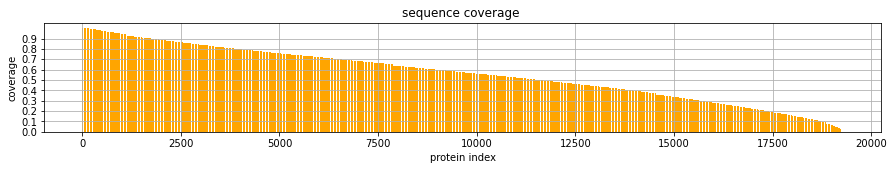

In [74]:
plt.figure(figsize=(15,2))
plt.bar(range(len(df_cover)), df_cover.coverage.values, color='orange')

plt.title('sequence coverage ')
plt.xlabel('protein index')
plt.ylabel('coverage')
plt.yticks(list(np.arange(0, 1, 0.1)))
plt.grid()
plt.show()

In [78]:
THRESHOLD = 0.5
remain_prot = df_cover.loc[df_cover.coverage>=THRESHOLD].protein.values
print('after protein sequence coverage >= 0.5 filtration : ', len(remain_prot))

digest_prot = remain_prot[:int(len(remain_prot)/2)]
detect_prot = remain_prot[int(len(remain_prot)/2):]

digest_idx = [idx for idx, _ in enumerate(df_ided_protein.PROTEIN.values) if _ in digest_prot]
detect_idx = [idx for idx, _ in enumerate(df_ided_protein.PROTEIN.values) if _ in detect_prot]
df_digest_protein = df_ided_protein.loc[digest_idx].reset_index(drop=True)
df_detect_protein = df_ided_protein.loc[detect_idx].reset_index(drop=True)
print(df_digest_protein.shape, df_detect_protein.shape)

after protein sequence coverage >= 0.5 filtration :  11707
(5853, 5) (5854, 5)


In [97]:
df_digest_protein.to_csv('data/uniprot/df_digest_protein.csv', index=False)
df_detect_protein.to_csv('data/uniprot/df_detect_protein.csv', index=False)

# 2. Detect_pep, unDetect_pep

In [103]:
df_detect_peptide = pep_detection_labelling(df_ided_protein = df_detect_protein)

del rows(including U, X amino acid) cnt : 50
peptide with 1 spectral count (remove this peptide) cnt :  30370
----ID/nonID cnt----
 0    496741
1    168244
Name: ID, dtype: int64
----final shape----
 (664985, 8)


In [104]:
df_detect_peptide.to_csv('data/uniprot/df_detect_peptide.csv', index=False)

* unDetectable sampling

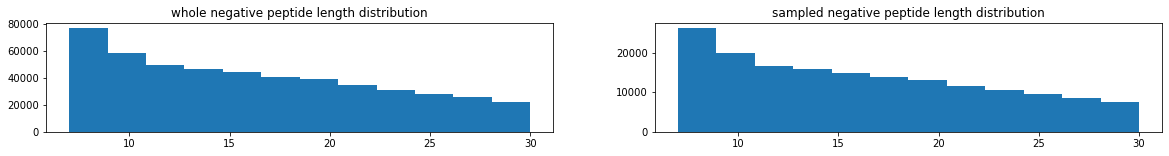

In [121]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 2)
ax[0].hist(df_detect_peptide.loc[df_detect_peptide.ID==0].PEP.apply(lambda x: len(x)).values, bins=12)
ax[0].set_title('whole negative peptide length distribution')
ax[1].hist(df_detect_peptide.loc[df_detect_peptide.ID==0].sample(168244, random_state=7).PEP.apply(lambda x: len(x)).values, bins=12)
ax[1].set_title('sampled negative peptide length distribution')
plt.show()

In [122]:
p = df_detect_peptide.loc[df_detect_peptide.ID==1]
n = df_detect_peptide.loc[df_detect_peptide.ID==0].sample(len(p), random_state=7)
df_detect_peptide_sampled = pd.concat([p, n], axis=0).reset_index(drop=True)

* train_test split (holdout)

In [130]:
hold = df_detect_peptide_sampled.sample(frac=0.2, random_state=7)
train = df_detect_peptide_sampled.drop(hold.index, axis=0)
print('---sampled ID/nonID cnt---\n', df_detect_peptide_sampled.ID.value_counts(),
      '\n---holdout ID/nonID cnt---\n', hold.ID.value_counts(),
      '\n---train   ID/nonID cnt---\n', train.ID.value_counts())

---sampled ID/nonID cnt---
 1    168244
0    168244
Name: ID, dtype: int64 
---holdout ID/nonID cnt---
 0    33706
1    33592
Name: ID, dtype: int64 
---train   ID/nonID cnt---
 1    134652
0    134538
Name: ID, dtype: int64


In [132]:
hold.to_csv('data/df_detect_peptide_test.csv', index=False)
train.to_csv('data/df_detect_peptide_train.csv', index=False)